# Machine Learning project
## Predicting Ratings from Text: A comparative Regression Experiment

### Imports and global configuration.

In [1]:
"""
Why:
- Centralize dependencies for reproducibility and clarity.
- Set global random seed to make splits and training repeatable.
"""

import re
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge

SEED = 42
OUT_DIR = Path("results")
OUT_DIR.mkdir(parents=True, exist_ok=True)


### Loading the data

In [3]:
# Why: verify schema early to avoid silent bugs later.
df = pd.read_csv("wine reviews.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(3)


Shape: (2890, 10)
Columns: ['Sl.No.', 'Brand', 'Name', 'Reviews Date Added', 'Reviews do Recommend', 'Reviews Num Helpful', 'Reviews Rating', 'Reviews Text', 'Reviews Title', 'Weight']


,Sl.No.,Brand,Name,Reviews Date Added,Reviews do Recommend,Reviews Num Helpful,Reviews Rating,Reviews Text,Reviews Title,Weight
0,1,Gallo,Ecco Domani174 Pinot Grigio - 750ml Bottle,2018-01-09T13:24:04Z,True,1.0,5.0,This a fantastic white wine for any occasion!,My Favorite White Wine,1.0 lbs
1,2,Fresh Craft Co.,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,2018-01-09T17:31:52Z,True,NaN,5.0,"Tart, not sweet...very refreshing and delicious!",Yum!!,2.45 lbs
2,3,1000 Stories,1000 Stories174 Zinfandel - 750ml Bottle,2018-01-09T17:31:51Z,True,NaN,5.0,I was given this wine so it was a delightful s...,A New Favorite!,3.09 lbs


### Preparation regression target

In [5]:
"""
Why:
- Supervised learning requires a known label (y).
- I won't impute the target; that would fabricate labels.
- I drop samples with missing/invalid ratings.
"""

TARGET_COL = "Reviews Rating"
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

n_before = len(df)
df = df.dropna(subset=[TARGET_COL]).copy()
n_after = len(df)

print(f"Dropped {n_before - n_after} rows with missing target; remaining: {n_after}")
print(df[TARGET_COL].describe())


Dropped 445 rows with missing target; remaining: 2445
count    2445.000000
mean        4.690798
std         0.843344
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Reviews Rating, dtype: float64


### Text cleaning function

In [7]:
"""
Why:
- Text pipelines work best with consistent formatting.
- Minimal normalization reduces noise while preserving meaning for TF-IDF.
"""

def clean_text(text: str) -> str:
    """
    Minimal text normalization.

    Parameters
    ----------
    text : str
        Raw input text (may be NaN / non-string).

    Returns
    -------
    str
        Cleaned text:
        - lowercased
        - HTML tags removed
        - whitespace normalized
    """
    text = str(text).lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


### Building a single text input column

In [9]:
"""
Why:
- A single 'text' column makes preprocessing clean (ColumnTransformer + TF-IDF).
- I join title + review body to capture both short and long cues.
"""

TITLE_COL = "Reviews Title"
TEXT_COL = "Reviews Text"

df[TITLE_COL] = df[TITLE_COL].fillna("")
df[TEXT_COL] = df[TEXT_COL].fillna("")

df["text"] = (df[TITLE_COL] + " " + df[TEXT_COL]).apply(clean_text)

X = df[["text"]]                  # DataFrame for ColumnTransformer
y = df[TARGET_COL].astype(float)  # regression target

X.head(3), y.head(3)


(                                                text
 0  my favorite white wine this a fantastic white ...
 1  yum!! tart, not sweet...very refreshing and de...
 2  a new favorite! i was given this wine so it wa...,
 0    5.0
 1    5.0
 2    5.0
 Name: Reviews Rating, dtype: float64)

In [11]:
df["text"]

0       my favorite white wine this a fantastic white ...
1       yum!! tart, not sweet...very refreshing and de...
2       a new favorite! i was given this wine so it wa...
3       bold, flavorful, aromatic, delicious this is a...
4       yum! plus, environmentally friendly! 4 750ml b...
                              ...                        
2885    excellent i only like a sweet wine. i was skep...
2886    delicious !! i ordered a 3 bottle set of both ...
2887    sumptuous delicious wine. i ordered the white ...
2888    excellent moscato this was my first purchase o...
2889    o'leary's select reserve chardonnay i don't kn...
Name: text, Length: 2445, dtype: object

### Frequency overview table for the paper

In [13]:
"""

Why:
- The instructions ask for a frequency overview table (samples, features, values).
- I'll compute counts and basic rating distribution summary.
"""

overview = {
    "n_samples_total": int(n_after),
    "n_features_used": 1,  # we use only "text" as input feature in classical pipeline
    "target_name": TARGET_COL,
    "target_min": float(y.min()),
    "target_max": float(y.max()),
    "target_mean": float(y.mean()),
    "target_std": float(y.std()),
}

rating_counts = y.value_counts().sort_index()

overview, rating_counts.head()


({'n_samples_total': 2445,
  'n_features_used': 1,
  'target_name': 'Reviews Rating',
  'target_min': 1.0,
  'target_max': 5.0,
  'target_mean': 4.69079754601227,
  'target_std': 0.8433437619454692},
 Reviews Rating
 1.0      69
 2.0      43
 3.0      65
 4.0     221
 5.0    2047
 Name: count, dtype: int64)

### Spliting the data into train/validation/test

In [15]:
"""

Why:
- Test set must be untouched until the final evaluation.
- Validation set supports sanity-checking before final test reporting.
"""

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED
)

print("Train/Val/Test:", len(y_train), len(y_val), len(y_test))
print("NaN in y_train?", np.isnan(y_train).any())


Train/Val/Test: 1711 367 367
NaN in y_train? False


### Regression metrics

In [17]:
"""

Why:
- Consistent metrics across all models is essential for fair comparison.
- MAE is the most interpretable for rating prediction.
"""

def regression_metrics(y_true, y_pred) -> dict:
    """
    Compute MAE, RMSE, R2.

    Returns
    -------
    dict
        { "MAE": ..., "RMSE": ..., "R2": ... }
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}


### Text preprocessing (TF-IDF)

In [19]:
"""

Why:
- TF-IDF is a standard text representation used in the course text pipeline style.
- ColumnTransformer keeps preprocessing inside the model pipeline, preventing leakage.
"""

text_preprocess = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2), "text")
    ],
    remainder="drop",
)


### Baseline model

In [21]:
"""

Why:
- A baseline is required to interpret whether real models beat trivial prediction.
- DummyRegressor(mean) predicts the mean rating from the training set.
"""

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(np.zeros((len(y_train), 1)), y_train)  # dummy ignores X

dummy_val_pred = dummy_model.predict(np.zeros((len(y_val), 1)))
print("Dummy (VAL):", regression_metrics(y_val, dummy_val_pred))


Dummy (VAL): {'MAE': 0.4982490281668383, 'RMSE': 0.8199331828083193, 'R2': -0.0008192775379809447}


### Classical model: Ridge regression

In [23]:
"""
Why Ridge:
- Linear models are strong baselines with TF-IDF.
- Ridge (L2 regularization) handles high-dimensional sparse features well.

Why GridSearchCV:
- Methodologically correct model selection (systematic hyperparameter tuning).
- CV on training set avoids leaking info from validation/test.
"""

ridge_pipe = Pipeline(steps=[
    ("prep", text_preprocess),
    ("model", Ridge(random_state=SEED))
])

ridge_grid = {
    "prep__tfidf__max_features": [10000, 20000],
    "model__alpha": [0.1, 1.0, 10.0],
}

ridge_search = GridSearchCV(
    ridge_pipe,
    param_grid=ridge_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)
print("Best Ridge params:", ridge_search.best_params_)
print("Best Ridge CV MAE:", -ridge_search.best_score_)


Best Ridge params: {'model__alpha': 1.0, 'prep__tfidf__max_features': 10000}
Best Ridge CV MAE: 0.4107616788738403


### Evaluation of the tuned Ridge model

In [24]:
"""
Why:
- Validation evaluation is a transparent checkpoint.
- Final test is used once for unbiased reporting.
"""

ridge_best = ridge_search.best_estimator_

ridge_val_pred = ridge_best.predict(X_val)
ridge_test_pred = ridge_best.predict(X_test)

print("Ridge (VAL):", regression_metrics(y_val, ridge_val_pred))
print("Ridge (TEST):", regression_metrics(y_test, ridge_test_pred))


Ridge (VAL): {'MAE': 0.4080295152420719, 'RMSE': 0.6422009303689535, 'R2': 0.38603926491404883}
Ridge (TEST): {'MAE': 0.46063097267540776, 'RMSE': 0.7853826636225073, 'R2': 0.26274610021183475}


## Neural Model

### Hugging face imports

In [27]:
"""
Why:
- Transformer fine-tuning is our required neural algorithm.
- I follow the fine-tuning workflow: tokenizer → tokenized dataset → Trainer.
"""

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import torch


### Building HF dataset and tokenization

In [29]:
"""
Why:
- Avoid fragile renaming steps.
- Explicitly create columns 'text' and 'labels'.
- Prevent hidden KeyErrors.
"""

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def make_hf_dataset(X_split, y_split):
    """
    Build a Hugging Face Dataset with guaranteed columns:
    - 'text'
    - 'labels'
    """
    df_tmp = pd.DataFrame({
        "text": X_split["text"].astype(str).values,
        "labels": y_split.astype(float).values
    })
    return Dataset.from_pandas(df_tmp, preserve_index=False)

hf_train = make_hf_dataset(X_train, y_train)
hf_val   = make_hf_dataset(X_val, y_val)
hf_test  = make_hf_dataset(X_test, y_test)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

hf_train_tok = hf_train.map(tokenize_batch, batched=True)
hf_val_tok   = hf_val.map(tokenize_batch, batched=True)
hf_test_tok  = hf_test.map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "labels"]
hf_train_tok.set_format(type="torch", columns=cols)
hf_val_tok.set_format(type="torch", columns=cols)
hf_test_tok.set_format(type="torch", columns=cols)

hf_train_tok[0]



Map:   0%|          | 0/1711 [00:00<?, ? examples/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

{'labels': tensor(5.),
 'input_ids': tensor([  101,  2182,  2024,  1996,  4436,  1045,  2066,  5621,  2009,  2003,
          2025,  4086,  1010,  1998,  1045,  2066,  2008,  1012,  2065,  2017,
          2066,  1996,  5510,  1997, 16619,  2300,  2007,  1996,  5770,  1997,
          1019,  6544,  1012,  2023,  2003,  2005,  2017,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

### Loading transformer model

In [31]:
"""
Why:
- We use a sequence-level head (like sequence classification),
  but with a single output neuron for numeric prediction.
"""

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type="regression"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Computation for evaluation

In [33]:
"""
Why:
- Trainer's default loss is used for optimization.
- We also compute MAE/RMSE/R2 for comparison with classical models.
"""

def compute_metrics(eval_pred):
    """
    Compute regression metrics for Hugging Face Trainer.

    eval_pred contains:
    - predictions: numpy array of shape (n, 1)
    - label_ids: numpy array of shape (n,)
    """
    preds, labels = eval_pred
    preds = preds.reshape(-1)   # (n,)
    labels = labels.reshape(-1)

    mae = np.mean(np.abs(preds - labels))
    rmse = np.sqrt(np.mean((preds - labels) ** 2))

    # R2 (safe implementation)
    ss_res = np.sum((labels - preds) ** 2)
    ss_tot = np.sum((labels - np.mean(labels)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)}


### Fine-tuning setup and training

In [35]:
"""
Why:
- TrainingArguments define batch size, epochs, evaluation strategy, etc.
- Trainer handles the training loop similarly to the course fine-tuning workflow.
"""

training_args = TrainingArguments(
    output_dir=str(OUT_DIR / "hf_runs"),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,         # keep small for project runtime; increase if you have time/GPU
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="mae",
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tok,
    eval_dataset=hf_val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/sg/yxd__f2956j_r__2hysv8r4c0000gn/T/ipykernel_94728/3066099915.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Rmse,R2
1,0.531000,0.377711,0.313076,0.614582,0.437713
2,0.313300,0.229748,0.241725,0.479320,0.657981


TrainOutput(global_step=428, training_loss=1.260967397244177, metrics={'train_runtime': 328.042, 'train_samples_per_second': 10.432, 'train_steps_per_second': 1.305, 'total_flos': 226647677088768.0, 'train_loss': 1.260967397244177, 'epoch': 2.0})

### Evaluation of the transformer model

In [37]:
"""

Why:
- Compare transformer neural approach against Ridge and baseline.
"""

val_metrics = trainer.evaluate(hf_val_tok)
test_metrics = trainer.evaluate(hf_test_tok)

val_metrics, test_metrics


({'eval_loss': 0.22974759340286255,
  'eval_mae': 0.2417249083518982,
  'eval_rmse': 0.4793199598789215,
  'eval_r2': 0.6579813659191132,
  'eval_runtime': 10.8462,
  'eval_samples_per_second': 33.837,
  'eval_steps_per_second': 4.241,
  'epoch': 2.0},
 {'eval_loss': 0.43173131346702576,
  'eval_mae': 0.2830975651741028,
  'eval_rmse': 0.6570625901222229,
  'eval_r2': 0.48397839069366455,
  'eval_runtime': 10.1921,
  'eval_samples_per_second': 36.008,
  'eval_steps_per_second': 4.513,
  'epoch': 2.0})

### Consolidate model comparison results and save into json file

In [39]:
"""
Why:
- The paper needs a comparative results table.
- Saving JSON ensures your write-up stays consistent with executed runs.
"""

dummy_test_pred = dummy_model.predict(np.zeros((len(y_test), 1)))

results = {
    "Dummy_mean": regression_metrics(y_test, dummy_test_pred),
    "Ridge_TFIDF": regression_metrics(y_test, ridge_test_pred),
    "Transformer_finetune": {
        "MAE": float(test_metrics["eval_mae"]),
        "RMSE": float(test_metrics["eval_rmse"]),
        "R2": float(test_metrics["eval_r2"]),
    }
}

with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(
        {
            "overview": overview,
            "rating_counts": rating_counts.to_dict(),
            "results_test": results,
            "ridge_best_params": ridge_search.best_params_,
            "transformer_model": MODEL_NAME,
            "split_seed": SEED,
        },
        f,
        indent=2,
    )

print("Saved:", OUT_DIR / "metrics.json")
results


Saved: results/metrics.json


{'Dummy_mean': {'MAE': 0.5458700474729152,
  'RMSE': 0.9155276211598263,
  'R2': -0.0018376760859972752},
 'Ridge_TFIDF': {'MAE': 0.46063097267540776,
  'RMSE': 0.7853826636225073,
  'R2': 0.26274610021183475},
 'Transformer_finetune': {'MAE': 0.2830975651741028,
  'RMSE': 0.6570625901222229,
  'R2': 0.48397839069366455}}

### Error analysis (ridge)

In [41]:
"""
Why:
- Instructions explicitly mention error analysis / discussion / visualization.
- We'll show the largest absolute errors to discuss typical failure cases.
"""

err_df = X_test.copy()
err_df["y_true"] = y_test.values
err_df["y_pred_ridge"] = ridge_test_pred
err_df["abs_err"] = np.abs(err_df["y_true"] - err_df["y_pred_ridge"])

err_df.sort_values("abs_err", ascending=False).head(10)


,text,y_true,y_pred_ridge,abs_err
250,yuck. i'm the type who usually rants and raves...,1.0,4.714817,3.714817
1971,only thing that really works!! of all the choi...,1.0,4.704282,3.704282
286,copy cat thise wine is a copy cat of the original,1.0,4.577945,3.577945
1833,excellent features my lips was very damage and...,1.0,4.444439,3.444439
494,drink mix not very tasty at all.,1.0,4.311463,3.311463
2741,found to be poor wish this could be a positive...,1.0,4.221451,3.221451
822,wings the wings were nasty,1.0,4.186146,3.186146
2876,worst purchase i have ever made! can't believe...,1.0,4.116347,3.116347
2506,what happened maybe more a question then the r...,1.0,4.039377,3.039377
1056,very expensive for one bottle the product adve...,1.0,3.928219,2.928219


## Visualization

In [100]:
"""
Why this cell:
- For visualizations we need predictions on the test set.
- We obtain them with trainer.predict(hf_test_tok).
"""

pred_out = trainer.predict(hf_test_tok)   # returns predictions + labels + metrics
bert_test_pred = pred_out.predictions.reshape(-1)  # shape (n,)

# Ground-truth labels (same as y_test, but taken from the HF output for safety)
bert_test_true = pred_out.label_ids.reshape(-1)

print("Shapes:", bert_test_true.shape, bert_test_pred.shape)
print("First 5 preds:", bert_test_pred[:5])


Shapes: (367,) (367,)
First 5 preds: [4.9764166 5.0763435 4.5277495 1.712825  5.1412606]


#### True vs Predicted Ratings

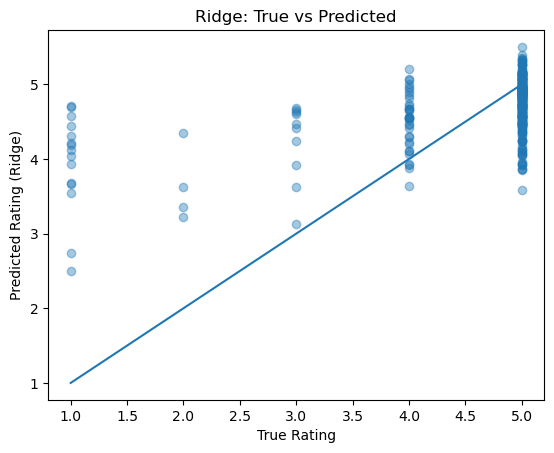

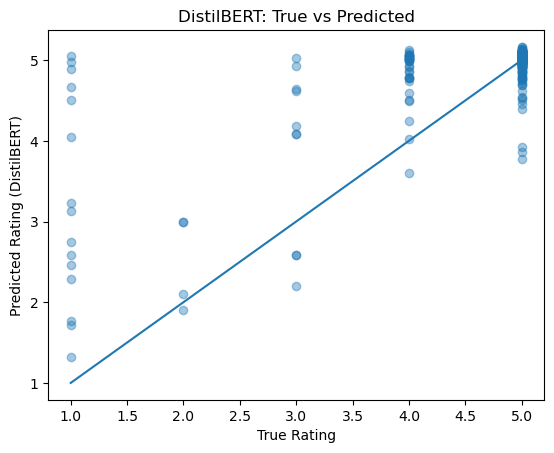

In [97]:
"""
Why:
- Checks calibration and bias.
- Ideal model -> points close to the diagonal.
"""

import matplotlib.pyplot as plt

# Ridge
plt.figure()
plt.scatter(y_test, ridge_test_pred, alpha=0.4)
plt.plot([1, 5], [1, 5])
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating (Ridge)")
plt.title("Ridge: True vs Predicted")
plt.show()

# Transformer
plt.figure()
plt.scatter(bert_test_true, bert_test_pred, alpha=0.4)
plt.plot([1, 5], [1, 5])
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating (DistilBERT)")
plt.title("DistilBERT: True vs Predicted")
plt.show()


Ridge predictions cluster around high values and miss low ratings, while BERT aligns more closely with the diagonal.

#### Histogram :Distribution of Absolute Errors

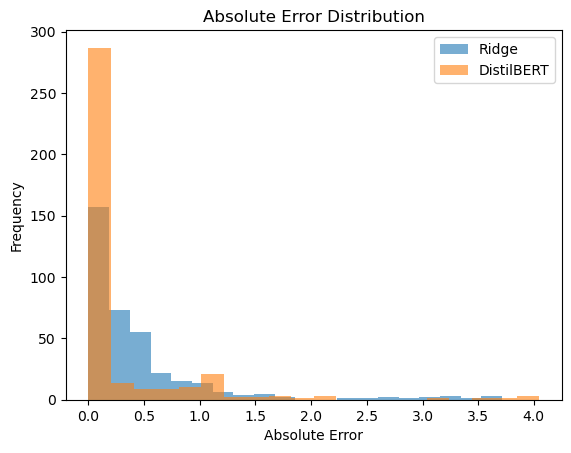

In [104]:
"""

Why:
- Shows how often the model makes small vs large mistakes.
- A long right tail indicates some very bad failures (like your Ridge 1-star cases).
"""

ridge_abs_err = np.abs(np.asarray(y_test) - np.asarray(ridge_test_pred))
bert_abs_err  = np.abs(np.asarray(bert_test_true) - np.asarray(bert_test_pred))

plt.figure()
plt.hist(ridge_abs_err, bins=20, alpha=0.6, label="Ridge")
plt.hist(bert_abs_err, bins=20, alpha=0.6, label="DistilBERT")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Absolute Error Distribution")
plt.legend()
plt.show()


#### Mean Absolute Error by True Rating

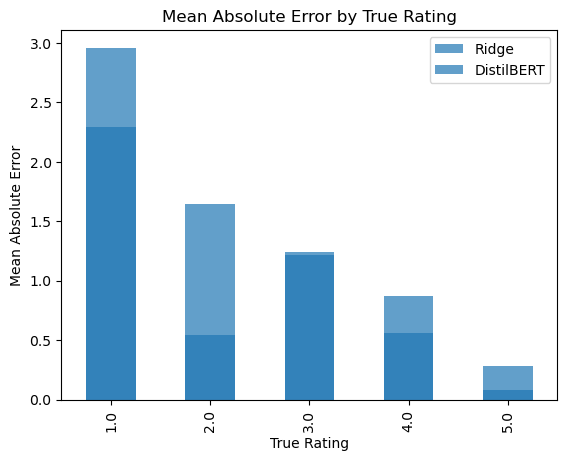

In [108]:
"""

Why:
- Detects systematic bias, e.g. Ridge failing much more on rating=1.
- Matches your error-analysis table where the biggest Ridge errors were all true rating = 1.0.
"""

err_df = pd.DataFrame({
    "true": np.asarray(y_test),
    "ridge_abs_err": ridge_abs_err,
    "bert_abs_err": bert_abs_err
})

ridge_by_rating = err_df.groupby("true")["ridge_abs_err"].mean()
bert_by_rating  = err_df.groupby("true")["bert_abs_err"].mean()

plt.figure()
ridge_by_rating.plot(kind="bar", alpha=0.7, label="Ridge")
bert_by_rating.plot(kind="bar", alpha=0.7, label="DistilBERT")
plt.xlabel("True Rating")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error by True Rating")
plt.legend()
plt.show()


In [118]:
from pathlib import Path

out_dir = Path("data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

train_df = X_train.copy()
train_df["Reviews Rating"] = y_train.values

val_df = X_val.copy()
val_df["Reviews Rating"] = y_val.values

test_df = X_test.copy()
test_df["Reviews Rating"] = y_test.values

train_df.to_csv(out_dir / "train.csv", index=False)
val_df.to_csv(out_dir / "val.csv", index=False)
test_df.to_csv(out_dir / "test.csv", index=False)

print("Saved to:", out_dir)


Saved to: data/processed
